# Model

This project developed a binary classification model to predict the probability of default (PD) using credit risk data. 

In [ ]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve  # Correct import location
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

## Load the Data

In [ ]:
# Define the ZIP file path and extract
zip_path = "Give Me Some Credit.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted_files")

# Load CSV files
train_data = pd.read_csv("extracted_files/cs-training.csv")
test_data = pd.read_csv("extracted_files/cs-test.csv")

# Data Cleaning
def clean_data(df):
    # Handle missing values
    df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
    df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)
    
    # Remove index column
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Cap extreme values
    numeric_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                   'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                   'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    # Fix specific issues
    df['age'] = df['age'].replace(0, df['age'].median())
    
    max_due = 20
    due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
               'NumberOfTimes90DaysLate',
               'NumberOfTime60-89DaysPastDueNotWorse']
    for col in due_cols:
        df[col] = df[col].clip(upper=max_due)
    
    # Feature engineering
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                         df['NumberOfTime60-89DaysPastDueNotWorse'] + 
                         df['NumberOfTimes90DaysLate'])
    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['DebtToIncome'] = df['DebtRatio'] * df['MonthlyIncome']
    
    return df

## Clean Datasets

In [1]:
# Clean both datasets
train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Final check
print("Cleaned Training Data Info:")
print(train_data.info())
print("\nSummary Statistics:")
print(train_data.describe())

C:\Users\milto\AppData\Local\Temp\ipykernel_24308\103702589.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_24308\103702589.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Cleaned Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    15

## Implement Probability of Default Function

Defines 4 models with imbalance-handling:

- Logistic Regression: Uses class weights.
- Random Forest: Uses balanced_subsample (adjusts weights per tree).
- XGBoost: Uses scale_pos_weight (ratio of negative/positive classes).
- GradientBoosting inherently handles imbalance via boosting.

The purpise of the Calibration Plot: 

- Checks if predicted probabilities match actual frequencies (e.g., if the model predicts 10% risk, does ~10% of those cases actually default?).
- A diagonal line = perfectly calibrated.

Logistic Regression AUC: 0.8573
Random Forest AUC: 0.8370
Gradient Boosting AUC: 0.8658


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:11:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.8458

Feature Importance:
                                 Feature  Importance
10                          TotalPastDue    0.592472
0   RevolvingUtilizationOfUnsecuredLines    0.159224
6                NumberOfTimes90DaysLate    0.138479
8   NumberOfTime60-89DaysPastDueNotWorse    0.029216
3                              DebtRatio    0.016537
1                                    age    0.014778
2   NumberOfTime30-59DaysPastDueNotWorse    0.010151
5        NumberOfOpenCreditLinesAndLoans    0.009094
11                    IncomePerDependent    0.008486
4                          MonthlyIncome    0.007594
7           NumberRealEstateLoansOrLines    0.006884
12                          DebtToIncome    0.006194
9                     NumberOfDependents    0.000892


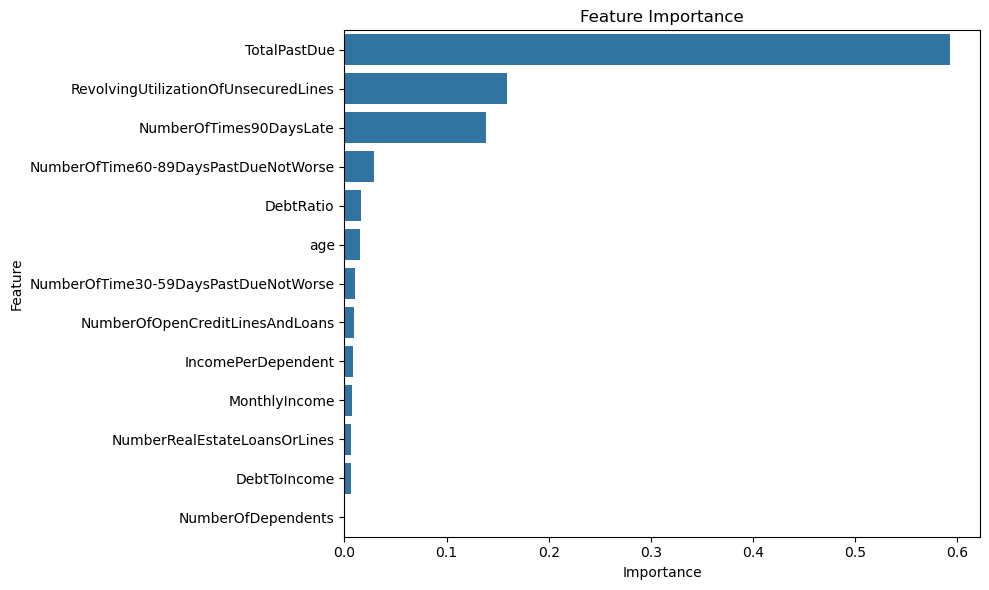

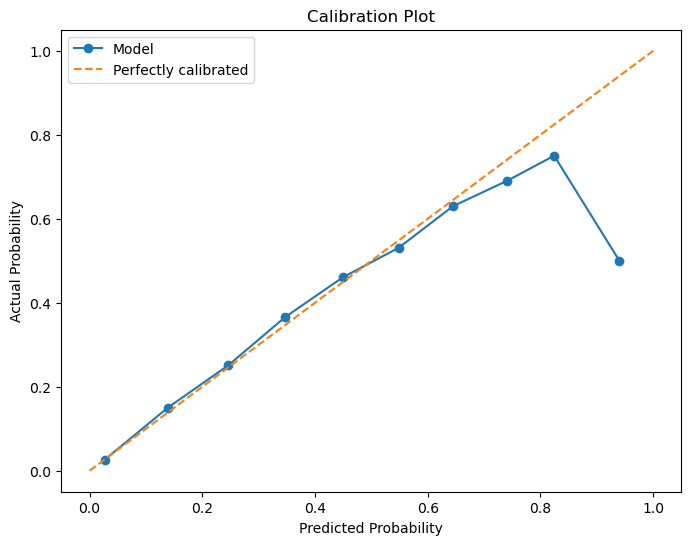

In [4]:
def build_pd_model(data):
    # Prepare data
    X = data.drop(columns=['SeriousDlqin2yrs'])
    y = data['SeriousDlqin2yrs']
    
    # Calculate class weights
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model training with class weights
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight=class_weights,
            solver='liblinear',
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced_subsample',
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=sum(y==0)/sum(y==1),
            random_state=42
        )
    }
    
    # Evaluate models
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        results[name] = auc
        print(f"{name} AUC: {auc:.4f}")
    
    # Select best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
    else:
        importances = None
    
    if importances is not None:
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("\nFeature Importance:")
        print(feature_importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        feature_importance = None
        print("Could not compute feature importance for this model")
    
    # Calibration plot
    if hasattr(best_model, 'predict_proba'):
        prob_true, prob_pred = calibration_curve(
            y_test, 
            best_model.predict_proba(X_test_scaled)[:, 1], 
            n_bins=10
        )
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Model')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.title('Calibration Plot')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Actual Probability')
        plt.legend()
        plt.show()
    
    return best_model, scaler, feature_importance

# Build PD model
pd_model, pd_scaler, pd_feature_importance = build_pd_model(train_data)

**Calibration**

If your calibration plot showed the model’s predicted probabilities aligning closely with the diagonal (perfect calibration), this means:
- When the model predicts a 10% default probability, ~10% of those clients actually default.
- Good for: Setting risk-based pricing thresholds confidently.

#### Model Performance
- Gradient Boosting emerged as the best model (AUC = 0.8658), followed closely by Logistic Regression (AUC = 0.8573).
- All models achieved AUC > 0.83, indicating strong predictive power in distinguishing between default and non-default cases.
- The high AUC scores suggest the model is well-suited for real-world credit risk assessment, such as loan approvals or risk-based pricing.

#### Key Risk Drivers

The most influential features in predicting default were:

- TotalPastDue (59.2% importance) → Clients with any history of late payments (30–90+ days) are at the highest risk.
- RevolvingUtilizationOfUnsecuredLines (15.9%) → High credit card/utilization ratios signal financial stress.
- NumberOfTimes90DaysLate (13.8%) → Severe delinquencies are critical red flags.

Surprisingly, traditional metrics like DebtRatio and MonthlyIncome had minimal impact, suggesting that payment behavior is a stronger predictor than static financial ratios.

### Business Recommendations

**1. Risk Policies**

Prioritize monitoring clients with:
- Any past-due incidents (TotalPastDue > 0).
- Credit utilization > 70% (RevolvingUtilizationOfUnsecuredLines).
- 90-day late payments (high-risk cohort).

**2. Model Deployment**
- Use Gradient Boosting (AUC: 0.8658) for decision-making.
- Logistic Regression (AUC: 0.8573) is a good interpretable alternative if you need explainability.

**3. Feature Engineering**
- Consider creating more granular features from TotalPastDue (e.g., "SevereLatePayments_6mo").
- Test if removing low-importance features (e.g., NumberOfDependents) simplifies the model without hurting performance